## This notebook illustrates unfolding using the RooUnfold methods 

In [47]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 
mpl.rcParams.update({'text.usetex' : False})

In [48]:
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

In [3]:
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, TH2D, cout, THStack
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldIds

from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

In [4]:
ROOT.gInterpreter.ProcessLine('#include "MyTUnfoldDensity.h"')


0L

In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [6]:
def getJetData(inputFiles, isMC=False, maxEvents = 5000000):
    
    cols = []
    scalar = []
  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')

    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('vertex_z')

    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    cols.append('jet_eta')

    
    if(isMC):
        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')
        
        scalar.append('gene_eta')
        scalar.append('gene_theta')
        scalar.append('gene_p')
        scalar.append('gene_pt')

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols,stop=maxEvents )
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [7]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

In [9]:
def getData(inputFiles,maxEvents = 5000000):
    
    cols = []
    scalar = []  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('vertex_z')

    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols,stop=maxEvents)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [10]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

In [29]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/gene_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)
        temp.eval('delta_pt = (jet_pt-genjet_pt)/genjet_pt',inplace=True)
        temp.eval('delta_p  = (jet_p-genjet_p)/genjet_p',inplace=True)
        temp.eval('delta_z  = (jet_z -genjet_z)/genjet_z',inplace=True)
        temp.eval('delta_dphi = jet_dphi-genjet_dphi',inplace=True)

    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [15]:
df_jet      = getJetData(['data.root'])
df_jet = applyCutsJets(df_jet)


Processed data.root in 7.8 seconds
abs(vertex_z)<25 and and vertex_z!=0 97815  fraction kept: 79.5
0.2 < y < 0.7 97815  fraction kept: 100.0
Q2>150 97815  fraction kept: 100.0
e_pt >15 31364  fraction kept: 32.1
jet_pt>10 25560  fraction kept: 81.5


In [30]:
mc_jet = getJetData(['rapgap.root'],isMC=True)#,maxEvents=500000)
mc_jet = applyCutsJets(mc_jet, isMC=True)

altmc_jet = getJetData(['djangoh.root'],isMC=True)#,maxEvents=200000)
altmc_jet = applyCutsJets(altmc_jet, isMC=True)


Processed rapgap.root in 51.3 seconds
abs(vertex_z)<25 and and vertex_z!=0 890253  fraction kept: 96.4
0.2 < y < 0.7 890253  fraction kept: 100.0
Q2>150 890253  fraction kept: 100.0
e_pt >15 360538  fraction kept: 40.5
jet_pt>10 290219  fraction kept: 80.5

Processed djangoh.root in 46.3 seconds
abs(vertex_z)<25 and and vertex_z!=0 862653  fraction kept: 96.3
0.2 < y < 0.7 862653  fraction kept: 100.0
Q2>150 862653  fraction kept: 100.0
e_pt >15 332329  fraction kept: 38.5
jet_pt>10 263232  fraction kept: 79.2


## define variables, binning, etc

In [33]:
coarsebins = 15
finebins = 15##15
minval = 2.5
maxval = np.pi
variable    = 'jet_dphi' 
genvariable = 'genjet_dphi'
namevariable = r'$\Delta\phi$'

#coarsebins = 7
#finebins = 7
#minval = 0.0
#maxval = 10
#variable = 'jet_qt'
#genvariable = 'genjet_qt'
#namevariable = r'$q_{T}'

#minval = 0.0 
#maxval = 1.0
#variable = 'jet_qtnormept'
#genvariable = 'genjet_qtnormept'


#coarsebins = 10
#finebins = 10
#minval = 0.0
#maxval = 1.5
#variable = 'jet_qtnormjetpt'
#genvariable = 'genjet_qtnormjetpt'
#namevariable = r'$q_{T}/p_{T}^{jet}$'

#coarsebins = 12
#finebins = 12
#minval = 0
#maxval = 1.2
#variable = 'jet_z'
#genvariable = 'genjet_z'
#namevariable = r'$z_{jet}$'


binwidth = (maxval - minval)/coarsebins

M = ROOT.TH2D("M", "Response Matrix", coarsebins,minval,maxval, finebins,minval,maxval)
M1 = M.Clone("M1")
M2 = M.Clone("M2")
M1.SetTitle("+1#sigma")
M2.SetTitle("-1#sigma")

scaleup = 1.001
scaledn = 0.999

eptmin = 20
eptmax = 25

## make data selection, split MC in two statistically independent samples

In [37]:
data_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f '%(eptmin,eptmax))
mc_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f '%(eptmin,eptmax))
altmc_cut = altmc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))


print len(mc_cut)
print len(altmc_cut)
#msk = np.random.rand(len(mc_cut)) < 0.10

#mctest_cut = mc_cut[msk]
#mc_cut   = mc_cut[~msk]
#print len(mctest_cut)
#print len(mc_cut)

68773
61973


<function matplotlib.pyplot.hist>

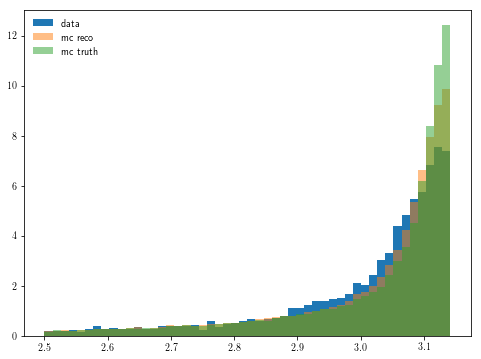

In [38]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(minval,maxval),bins=50,normed=True,label='data')
plt.hist(mc_cut[variable],range=(minval,maxval),bins=50,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(minval,maxval),bins=50, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False)
plt.hist

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 <a list of 9 Text xticklabel objects>)

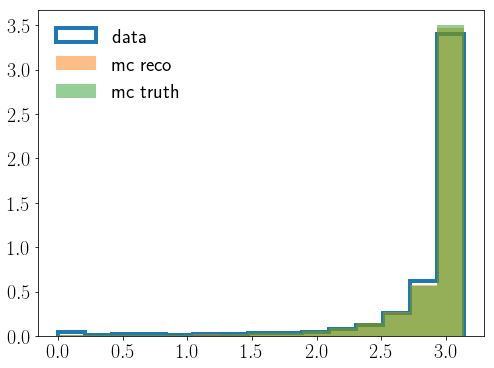

In [36]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,histtype='step',linewidth=4.0,label='data')
plt.hist(mc_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(0,maxval),bins=coarsebins, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False,fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

## Fill response matrix

In [39]:
Npe = len(mc_cut[variable])

response= RooUnfoldResponse(coarsebins, minval, maxval,
                            finebins , minval, maxval);
response.UseOverflow()

for i in np.arange(len(mc_cut[variable])):
    x = mc_cut.iloc[i][variable]
    y = mc_cut.iloc[i][genvariable]
    M.Fill(x, y, 1./Npe)
    response.Fill(x, y);
#
#plt.hist(df_cut['jet_qt'],bins=10,range=(0,10.0),normed=True,alpha=0.9, label='MC reco',histtype='step',lw=2)


## Plot response matrix

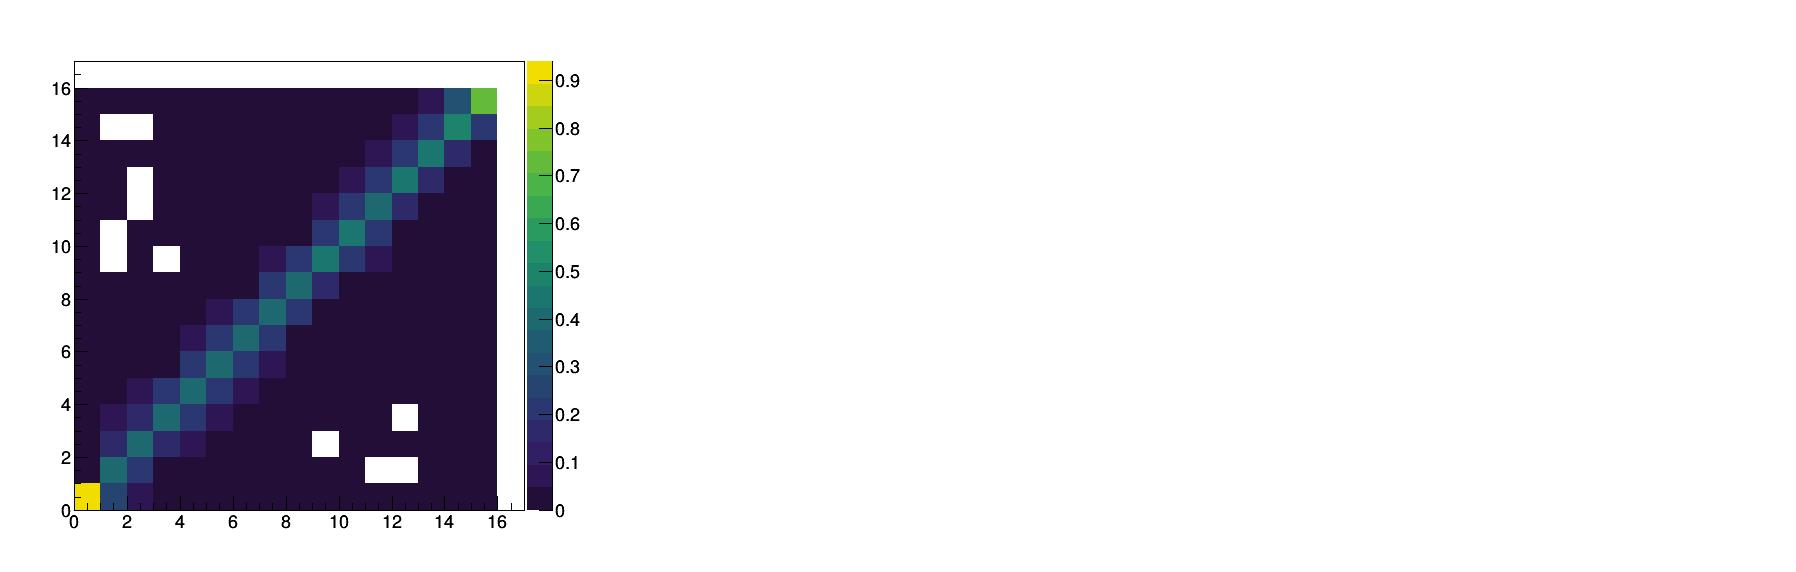

In [40]:
ROOT.gStyle.SetOptStat("")
ROOT.gStyle.SetPalette(ROOT.kViridis);
ROOT.gStyle.SetTitleYOffset(0.85)
ROOT.gStyle.SetEndErrorSize(10)


c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
response.Mresponse().Draw("colz")
c0.Draw()

## fill mc truth and mc reco histograms

In [41]:
h_mcreco = ROOT.TH1D("h_mcreco", "h_mcreco", coarsebins, minval, maxval)
h_mctrue = ROOT.TH1D("h_mctrue", "h_mctrue", finebins, minval, maxval)
   
for i in np.arange(len(mc_cut[variable])):
    h_mctrue.Fill(mc_cut.iloc[i][genvariable])
    h_mcreco.Fill(mc_cut.iloc[i][variable])


## Create data histogram and pseudodata histogram 

In [42]:
h_fakedata = ROOT.TH1D("h_fakedata", "h_fakedata", coarsebins, minval,maxval)   
    
for i in np.arange(len(data_cut[variable])): #fill a fake data histo with as much data as real data (obbiously it assumes you have more MC)
    h_fakedata.Fill(altmc_cut.iloc[i][variable])
       
h_data = ROOT.TH1D("h_data", "h_data", coarsebins, minval, maxval)   
for i in np.arange(len(data_cut[variable])):
    h_data.Fill(data_cut.iloc[i][variable])

## Plot mc truth, mc reco, data, and pseudodata

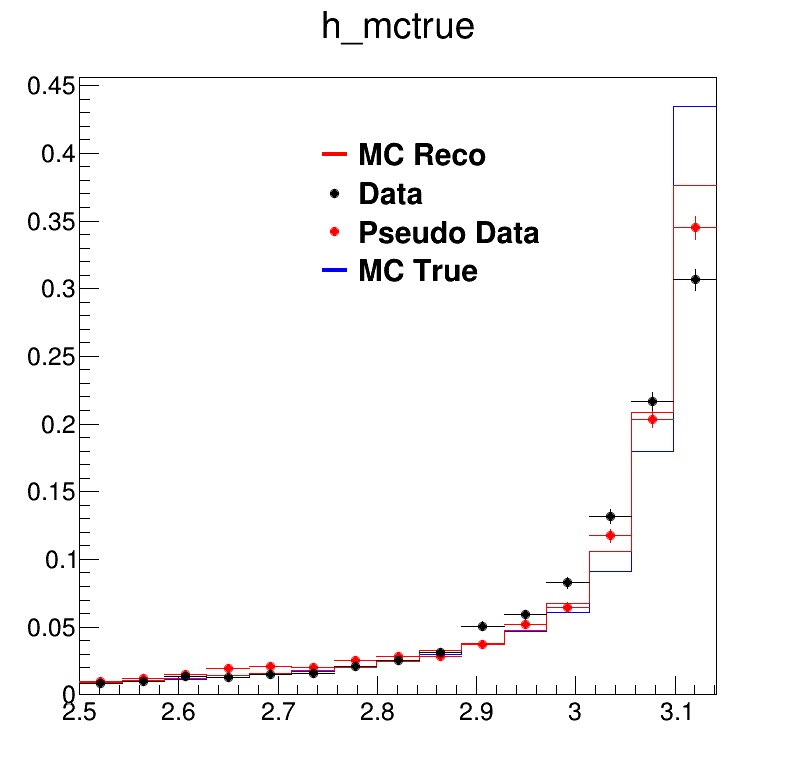

In [43]:
#h_mcreco.SetMarkerStyle(20)
h_data.SetMarkerStyle(20)
h_data.SetMarkerColor(ROOT.kBlack)
h_data.SetLineColor(ROOT.kBlack)

#h_mctrue.SetMarkerStyle(21)
h_fakedata.SetMarkerColor(ROOT.kRed)
h_fakedata.SetLineColor(ROOT.kRed)

h_fakedata.SetLineWidth(1)

h_fakedata.SetMarkerStyle(20)
h_mctrue.SetLineColor(ROOT.kBlue)
h_mcreco.SetLineColor(ROOT.kRed)
#h_fakedata.SetLineColor(ROOT.kBlue)
#h_mctrue.SetLineColor(ROOT.kRed)

creco = ROOT.TCanvas("creco", "creco", 800, 800)
h_mctrue.DrawNormalized()
h_mctrue.SetMinimum(0.0)
h_mcreco.DrawNormalized('same')
h_fakedata.DrawNormalized("e same")
h_data.DrawNormalized("e same")

creco.Draw()

ROOT.gStyle.SetOptStat("")


label = Legend("")
label.Add( h_mcreco, 'MC Reco', 'L')
label.Add(h_data, 'Data','P')
label.Add(h_fakedata, 'Pseudo Data', 'P')
label.Add( h_mctrue, 'MC True', 'L')
label.Draw(.4,.85)


## Plot response matrix and projections

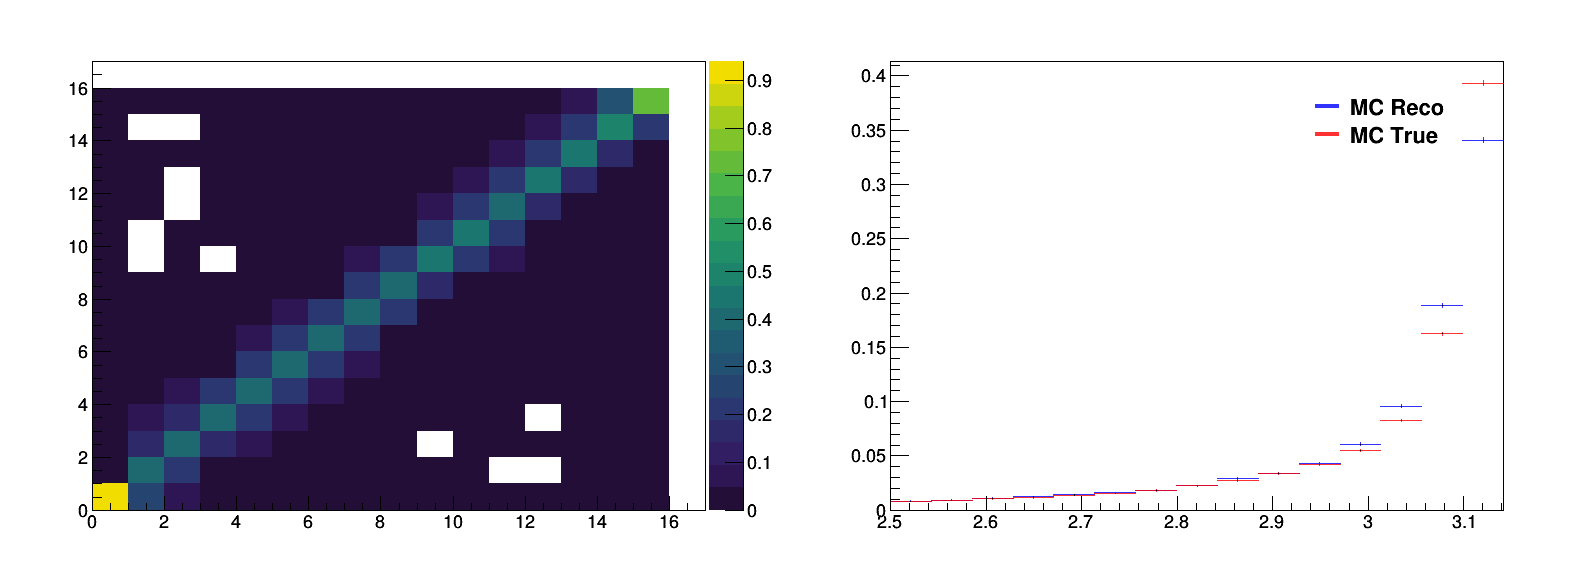

In [44]:
mc_truth = M.ProjectionY()
mc_reco = M.ProjectionX()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
response.Mresponse().Draw("colz")
#responseMatrix.Draw('colz')
#response.Mresponse().SetTitle('Response Matrix; Reconstructed; True')

#ROOT.gPad.SetLogz()
c.cd(2)


label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
#hs_mc.SetTitle(axestitle[variable])

label.Draw(0.65,.87)
c.Draw()

# Define input for unfolding, create dictionaries to store results

In [45]:
data_inputforunfolding = h_data.Clone()

data_unfolded = {}
Covariance = {}
InverseCovariance  = {}
correlation = {}
unfold = {}

# Find appropiate number of iterations for the Bayesian Unfolding

In [46]:
## Computes the global correlation coefficient
def get_averagerho(cov,inversecov):
    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    rhos = []
    for i in range(nrows) :
        #print np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i)))
        if(cov(i,i)*inversecov(i,i)!=0):
            rhos.append( np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i))))
        else:
            print 'something messed up with the inverse cov or cov'
    #print rhos
    return np.average(rhos)


def GetCorrelationMatrix ( cov, name):

    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    
    h= ROOT.TH2D (name, "", nrows, 0, nrows, ncolumns, 0, ncolumns);
    h.SetAxisRange (-1.0, 1.0, "Z")
    for i in range(nrows) :
        for j in range(ncolumns) :
            Viijj= cov(i,i)*cov(j,j)
            if Viijj>0.0: h.SetBinContent (i+1, j+1, cov(i,j)/ROOT.TMath.Sqrt(Viijj))
            
    return h

## Do check convergence of iterative unfolding procedure. Check Correlation matrices and the unfolded result. We expect the correlation matrix to show **negative** correlation between adjacent bins. If we see too much large positive correlations, it means that the unfolding has not converged yet. 

In [49]:
c = ROOT.TCanvas('c','c',1600,1600)
c.Divide(4,8)
for i in range(1,30):
    unfold['Bayes_iter%i'%i] = RooUnfoldBayes(response, data_inputforunfolding, i)
    h = unfold['Bayes_iter%i'%i].Hreco();
    Covariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Ereco();
    InverseCovariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Wreco();
    correlation['Bayes_iter%i'%i] = GetCorrelationMatrix(Covariance['Bayes_iter%i'%i], 'Bayes_iter%i'%i)
    
    #c.cd(i-2)#i-2
    #h.Scale(1.0/h.Integral())
    #h.Draw()
    #h.SetLineColor(i)
    
#c.Draw()

Now unfolding...
Iteration : 0
Chi^2 of change 37.6752
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 37.6752
Iteration : 1
Chi^2 of change 7.70226
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 37.6752
Iteration : 1
Chi^2 of change 7.70226
Iteration : 2
Chi^2 of change 2.45762
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 37.6752
Iteration : 1
Chi^2 of change 7.70226
Iteration : 2
Chi^2 of change 2.45762
Iteration : 3
Chi^2 of change 1.12154
Calculating covariances due to number o

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


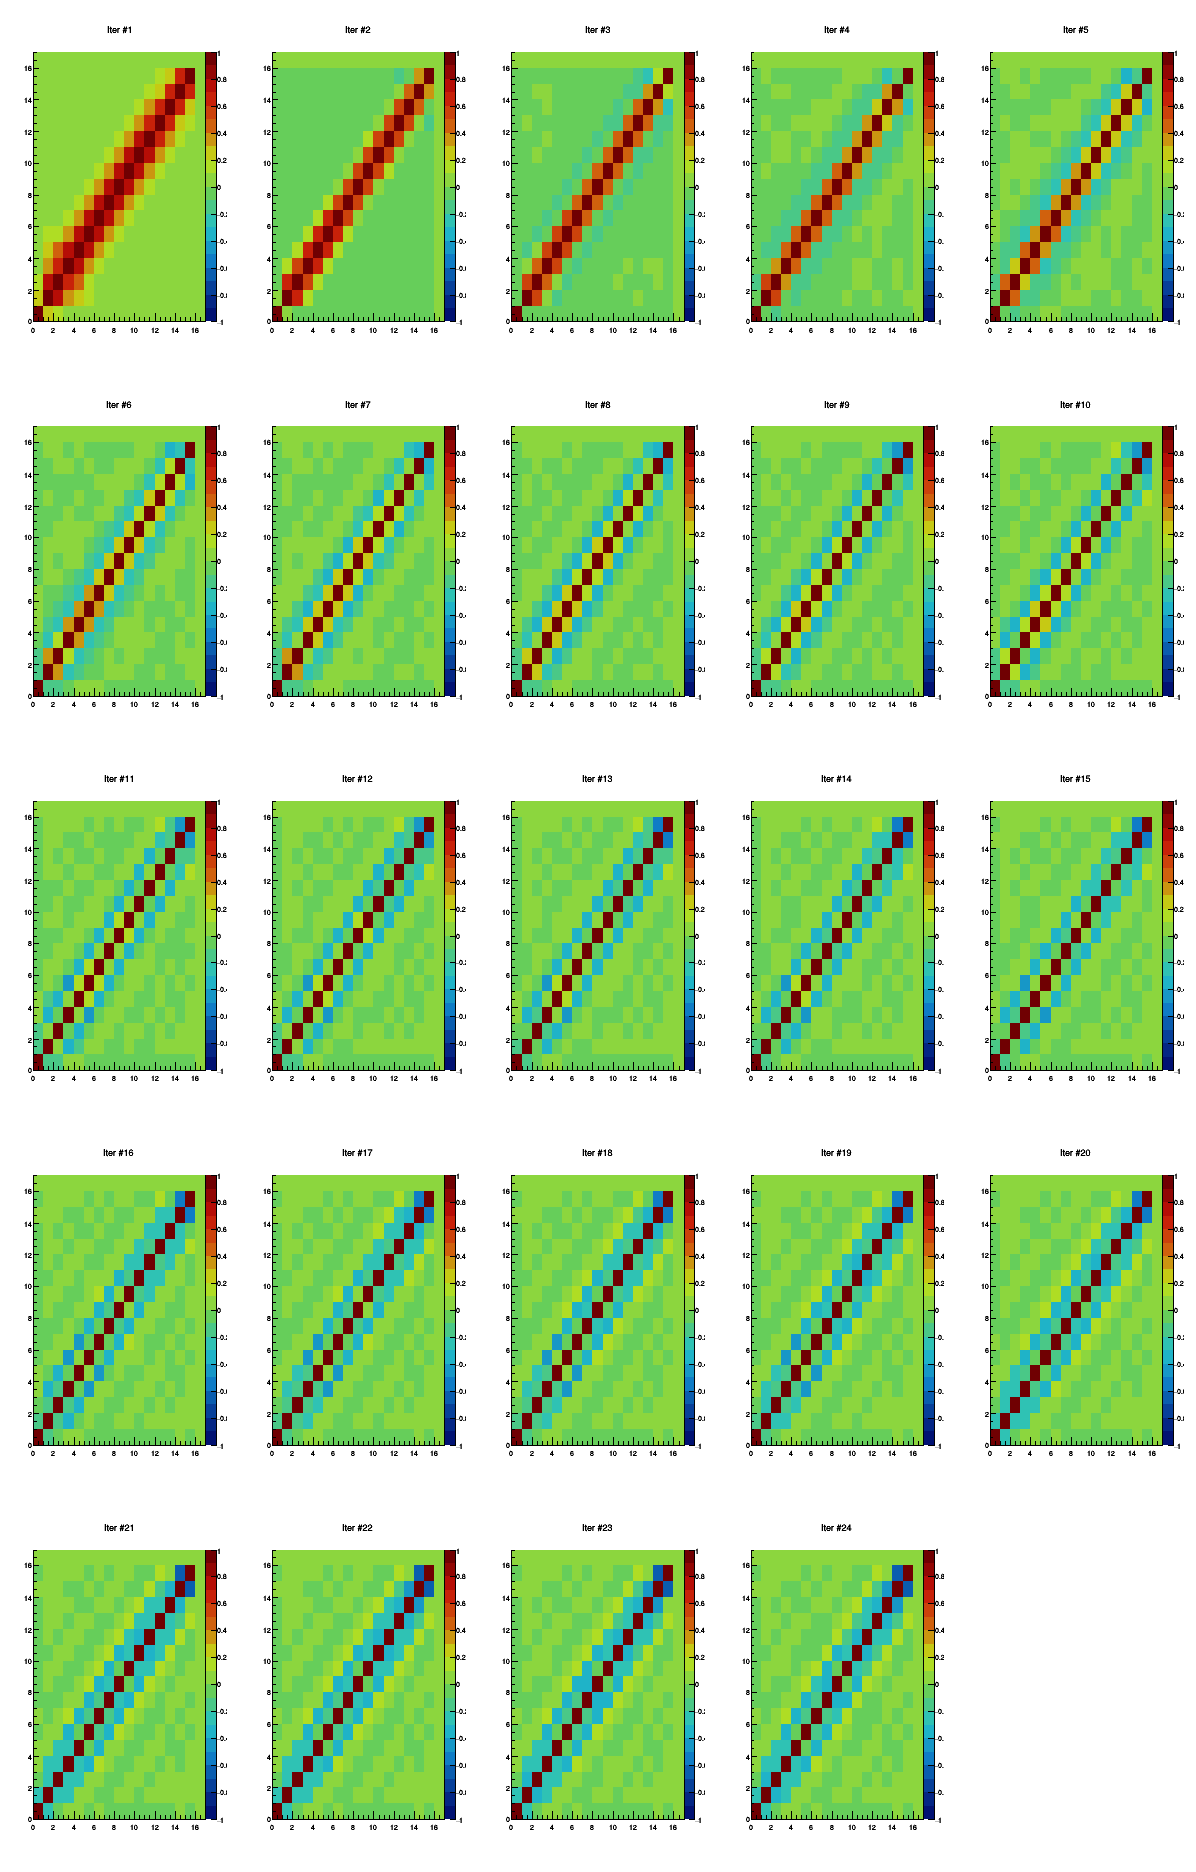

In [50]:
c = ROOT.TCanvas('c','c',1200,1900)
c.Divide(5,5)
ROOT.gStyle.SetPalette(ROOT.kRainBow);

rho = []
iteration = []
for i in range(1,25):
    c.cd(i)
    correlation['Bayes_iter%i'%i].SetTitle('Iter #%i'%i)
    correlation['Bayes_iter%i'%i].Draw('colz')
    #Covariance['Bayes_iter%i'%i].SetTitle('Iter #%i'%i)
    #Covariance['Bayes_iter%i'%i].Draw('colz')
    
    rho.append(get_averagerho(Covariance['Bayes_iter%i'%i],InverseCovariance['Bayes_iter%i'%i]))
    iteration.append(i)
#print rho
c.Draw()

## Average global correlation coefficient vs number of iterations
## the global correlation coefficient for bin i is defined as
## rho_i = sqrt[ 1 - 1/(Cov_ii*InverseCov_ii)]
## Take average of all rho_i and stsudy dependence of the number of iterations. Should take the minimum.

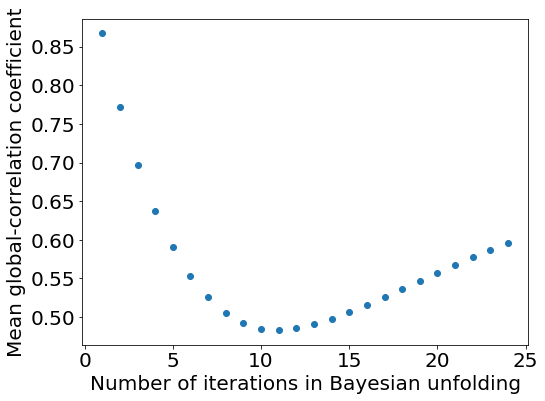

The number of iterations that results in the minimum average global correlation coefficient is 10
The minimum average global correlation coefficient is 0.48


In [51]:
fig = plt.figure(figsize=(8,6))
plt.plot(iteration,rho,'o')
plt.xlabel('Number of iterations in Bayesian unfolding',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()
print 'The number of iterations that results in the minimum average global correlation coefficient is', np.argmin(rho)
print 'The minimum average global correlation coefficient is %2.2f'%min(rho)

#nbayes_iter = np.argmin(rho)
nbayes_iter = 4

## Perform unfolding with optimal number of iterations (found above)

In [52]:


unfold['Bayes'] = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter)
#RooUnfoldTUnfold(response, data_inputforunfolding) # 
unfold['Bayes'].IncludeSystematics()


data_unfolded['Bayes'] = unfold['Bayes'].Hreco()
Covariance['Bayes'] = unfold['Bayes'].Ereco();
#unfold['Bayes'].PrintTable (cout, mc_truth)


Now unfolding...
Iteration : 0
Chi^2 of change 37.6752
Iteration : 1
Chi^2 of change 7.70226
Iteration : 2
Chi^2 of change 2.45762
Iteration : 3
Chi^2 of change 1.12154
Calculating covariances due to number of measured events
Calculating covariance due to unfolding matrix...


## Error matrix

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


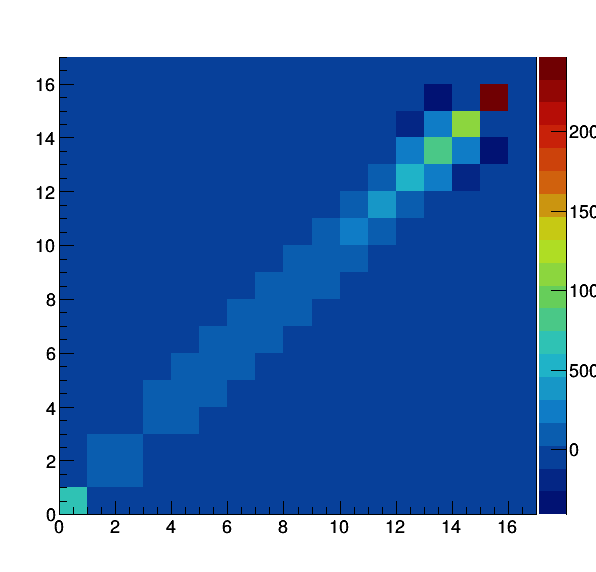

In [53]:
c = ROOT.TCanvas('c','c',600,600)
Covariance['Bayes'].Draw("colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


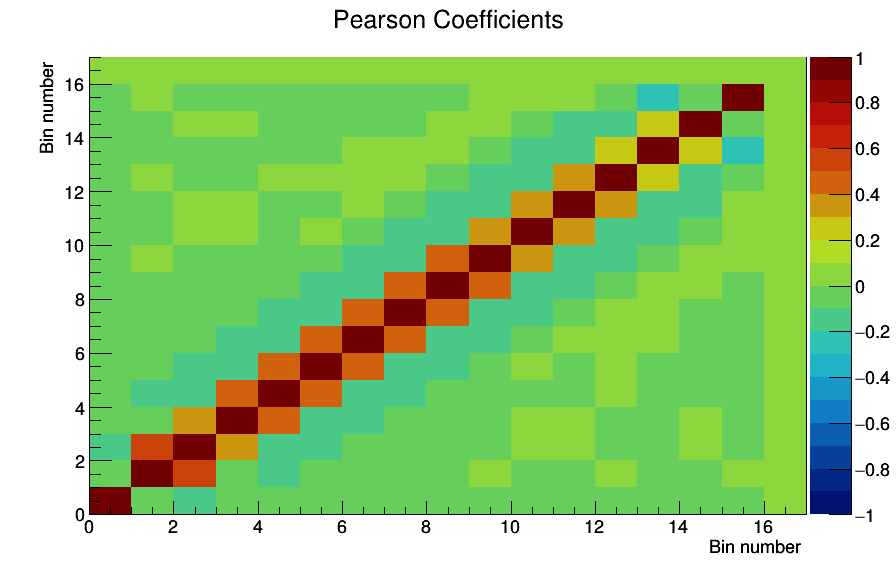

In [54]:
ROOT.gStyle.SetPalette(ROOT.kRainBow);

c = ROOT.TCanvas('c','c',900,600)
correlation = {}

correlation['Bayes'] = GetCorrelationMatrix(Covariance['Bayes'], 'Bayes')
correlation['Bayes'].Draw('colz')
#correlation['Bayes'].GetXaxis().SetRangeUser(1,7)
#correlation['Bayes'].GetYaxis().SetRangeUser(1,7)
correlation['Bayes'].GetXaxis().SetTitle('Bin number')
correlation['Bayes'].GetYaxis().SetTitle('Bin number')
correlation['Bayes'].SetTitle('Pearson Coefficients')
correlation['Bayes'].GetZaxis().SetRangeUser(-1.0,1.0)
c.Draw()

## Compare data after unfolded, data at reconstructed level, and MC truth

Bayes   1   2.52138642179  0.008  0.001
Bayes   2   2.56415926536  0.009  0.001
Bayes   3   2.60693210893  0.012  0.002
Bayes   4   2.6497049525  0.012  0.001
Bayes   5   2.69247779608  0.014  0.002
Bayes   6   2.73525063965  0.015  0.002
Bayes   7   2.77802348322  0.020  0.002
Bayes   8   2.82079632679  0.023  0.002
Bayes   9   2.86356917037  0.029  0.002
Bayes   10   2.90634201394  0.049  0.003
Bayes   11   2.94911485751  0.062  0.004
Bayes   12   2.99188770109  0.080  0.004
Bayes   13   3.03466054466  0.125  0.006
Bayes   14   3.07743338823  0.198  0.007
Bayes   15   3.1202062318  0.343  0.010
[2.52138642 2.56415927 2.60693211 2.64970495 2.6924778  2.73525064
 2.77802348 2.82079633 2.86356917 2.90634201 2.94911486 2.9918877
 3.03466054 3.07743339 3.12020623]
[0.00815186 0.00933698 0.01241492 0.0122933  0.01396394 0.01534983
 0.01967503 0.02349656 0.02943864 0.04910232 0.06150201 0.07994066
 0.12473859 0.19750133 0.34309404]
[0.00140638 0.00140661 0.00165659 0.00149774 0.00168574 0.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


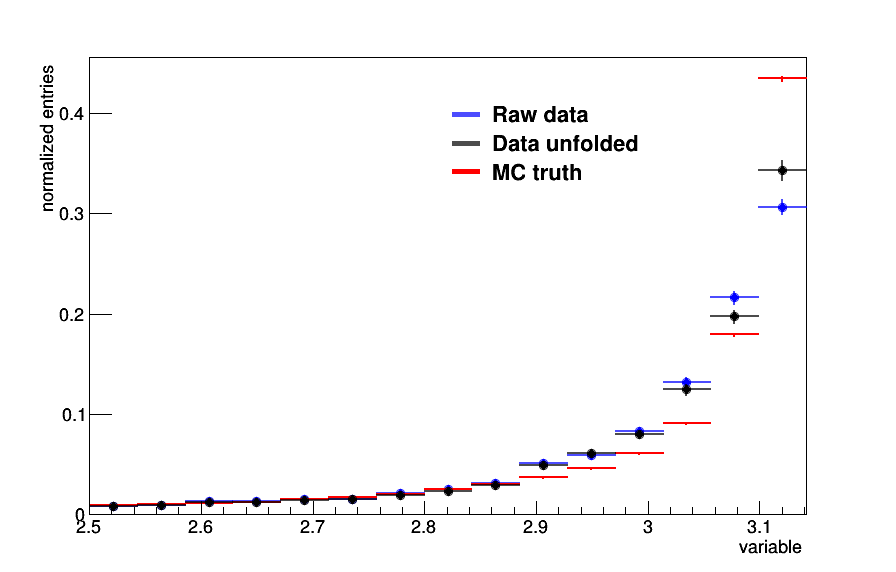

In [55]:
c = ROOT.TCanvas('c','c',900,600)

label = Legend("")
alpha = 0.7
hstack = ROOT.THStack()
h_data.SetLineWidth(2)
h_data.SetLineColorAlpha(4,alpha)
h_data.SetMarkerColor(4)
mc_truth.SetLineColor(2)
mc_truth.SetLineWidth(2)
mc_truth.SetMarkerColor(2)

h_data.SetMarkerStyle(20)

color = {}
color['Bayes'] = 1

h_data.Scale(1.0/h_data.Integral())
mc_truth.Scale(1.0/mc_truth.Integral())


result_x = np.array([])
result_y = np.array([])
result_erry = np.array([])

for key in ['Bayes']:
    data_unfolded[key].SetMarkerStyle(20)
    data_unfolded[key].SetLineWidth(2)
    data_unfolded[key].SetLineColorAlpha(color[key],alpha)
    data_unfolded[key].SetMarkerColor(color[key])
    data_unfolded[key].Scale(1.0/data_unfolded[key].Integral())

    for i in range(1,data_unfolded[key].GetNbinsX()+1):
        print key, ' ' , i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_unfolded[key].GetBinContent(i), ' %2.3f'%data_unfolded[key].GetBinError(i)
        result_x = np.append(result_x, data_unfolded[key].GetBinCenter(i))
        result_y = np.append(result_y, data_unfolded[key].GetBinContent(i))
        result_erry = np.append(result_erry, data_unfolded[key].GetBinError(i))
hstack.Add(h_data)
hstack.Add(mc_truth)
hstack.Add(data_unfolded['Bayes'])
label.Add(h_data, 'Raw data', 'L')
label.Add(data_unfolded['Bayes'],'Data unfolded','L')      
label.Add(mc_truth, 'MC truth', 'L')

hstack.SetTitle('; variable; normalized entries')
hstack.Draw('nostack')
hstack.GetYaxis().SetNdivisions(6)
label.Draw(.5,.85)

c.Draw()
print result_x
print result_y
print result_erry
#c.SaveAs('Unfoldedresult%s.pdf'%(datatype))

## Closure test: feed pseudodata (MC) to the unfolding and test whether it is compatible with the truth distribution

In [ ]:
#data_inputforunfolding = h_data.Clone()
data_inputforunfolding = h_fakedata.Clone()
closure = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter).Hreco();


In [ ]:
c = ROOT.TCanvas()
closure.SetLineColor(1)
closure.SetMarkerColor(2)
closure.Scale(1/closure.Integral())
closure.SetTitle('Closure test')
closure.Draw()
mc_truth.Draw('same')
label = Legend("")
label.Add(closure, 'MC reco, unfolded', 'L')
label.Add(mc_truth, 'MC truth' ,     'L')
label.Draw(.15,.90)

c.Draw()

In [ ]:
temp = closure.Clone('temp')
temp.Divide(mc_truth)
c = ROOT.TCanvas()
temp.Draw()
temp.SetMinimum(0.5)
temp.SetMaximum(1.5)
temp.SetTitle('Closure test')
c.Draw()

# Multiply the unfolded result by the response matrix, compare with data. This is the "refolded check"

In [ ]:
c = ROOT.TCanvas()

#response.Mresponse().Draw("colz")
    
nrows= response.Mresponse().GetNrows()
ncolumns = response.Mresponse().GetNcols()
    
##print nrows
#print ncolumns
temp = 0

refolded = data_unfolded['Bayes'].Clone('refolded')

##element #1 will be:
for n in range(1,nrows):
    temp = 0
    for i in range(1,nrows):
        #print 'element #%i'%i, ' '  , response(i,n)
        temp = temp +  response(n,i)*data_unfolded['Bayes'].GetBinContent(i)
    print temp
    refolded.SetBinContent(n,temp)
#c.Draw()

#print type(data_unfolded['Bayes'])

#for i in range(1,nrows):
    #print data_unfolded['Bayes'].GetBinContent(i)
    
    
c = ROOT.TCanvas()

refolded.SetLineColor(2)
refolded.SetMarkerColor(2)
hs = ROOT.THStack()
hs.Add(refolded)
hs.Add(data_unfolded['Bayes'])
hs.Add(h_data)
label = Legend("")
label.Add(data_unfolded['Bayes'],'Data unfolded','L')      
label.Add(refolded, 'Data unfolded -> refolded', 'L')
label.Add(h_data, 'Raw data', 'L')


hs.Draw('nostack')

label.Draw(0.4,0.8)
c.Draw()

# Final plot, unfolded result vs MC truth

In [ ]:
rc('text', usetex=True)


fig = plt.figure(figsize=(8,6))


df_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
printSummary(df_cut)
print '###########'
    
plt.hist(df_cut[genvariable],bins=coarsebins,range=(minval,maxval),normed=True,histtype='step',label='Rapgap')    

df_cut = altmc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
printSummary(df_cut)
print '###########'
    
plt.hist(df_cut[genvariable],bins=coarsebins,range=(minval,maxval),normed=True,histtype='step',label='Djangoh')    

plt.errorbar(x=result_x,y=np.divide(result_y,binwidth), yerr=np.divide(result_erry,binwidth), fmt='o',ls='none',label='Data',color='black')

plt.xlabel(namevariable, fontsize=25)
plt.ylabel(r'$1/\sigma \times d\sigma$ ', fontsize=25)
#plt.tick_params('both',labelsize=20)

plt.title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f \mathrm{~GeV}, 0.2<y<0.7$'%(eptmin,eptmax),fontsize=21)
#plt.text(0.05,1.2, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(eptmin,eptmax) + '$\ \mathrm{ GeV}$ \n' +
#                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.legend(loc='best',frameon=False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#plt.yscale('log')
plt.legend(prop={'size': 20}, frameon=False, loc='best')
#plt.legend(loc='best',frameon=False)
plt.savefig('finalplot.png', bbox_inches='tight')
plt.savefig('finalplot.pdf', bbox_inches='tight')

